#### Colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd "gdrive/My Drive/Colab Notebooks"  # changeme

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from ipywidgets import IntSlider, interact, fixed

In [2]:
import common
import helpers
import processing.prune as prune
import processing.statistics as statistics
from architecture.layers import MaskedLinear, MaskedConv2d
from architecture.models import PruningModule, LeNet_20_100, LeNet_300_10, Conv2_30
from processing.snapshots import Snapshots
from data import get_mnist, get_cifar
from experiment import Experiment

In [3]:
def save_results(output_dir, layers):
    s = Snapshots(output_dir)
    fp_paths = {}
    ip_paths = {}
    norms_paths = {}
    graph_specs = {}
    for layer in layers:
        fp_path, ip_path, norms_path = s.save_computed_metrics(layer)
        fp_paths[layer] = fp_path
        ip_paths[layer] = ip_path
        norms_paths[layer] = norms_path
        graph_specs[layer] = s.create_adjacency(layer)
        
    return fp_paths, ip_paths, norms_paths, graph_specs

## Model selection

### MNIST / Lenet 300-100-10

#### Loading the data

In [4]:
train_batch_size = 16
test_batch_size = 1000

In [5]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

#### Defining the model

In [6]:
# Only requirement is to inherit PruningModule and to use MaskedLinear and MaskedConv2d
class LeNet_300_100(PruningModule):
    def __init__(self, bias=True):
        super(LeNet_300_100, self).__init__(bias)
        self.fc1 = MaskedLinear(28 * 28, 300, bias=bias)
        self.fc2 = MaskedLinear(300, 100, bias=bias)
        self.fc3 = MaskedLinear(100, 10, bias=bias)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model_class = LeNet_300_100
layers = ["fc1", "fc2", "fc3"]

In [9]:
epochs = 10
optim_kwargs = {"lr": 0.003, "momentum": 0.9}
criterion = nn.CrossEntropyLoss()
model = model_class(bias=False)
optimizer = optim.SGD(model.parameters(), **optim_kwargs)

### CIFAR-10 / Conv-2

#### Loading the data

In [ ]:
train_batch_size = 64
test_batch_size = 1000

In [ ]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

#### Defining the model

In [4]:
class Conv2(PruningModule):
    def __init__(self, bias=True):
        super(Conv2, self).__init__(bias)
        self.conv1 = MaskedConv2d(3, 64, 3, bias=bias)
        self.conv2 = MaskedConv2d(64, 64, 3, bias=bias)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = MaskedLinear(64 * 14 * 14, 256, bias=bias)
        self.fc2 = MaskedLinear(256, 256, bias=bias)
        self.fc3 = MaskedLinear(256, 10, bias=bias)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model_class = Conv2
layers = ["conv1", "conv2", "fc1", "fc2", "fc3"]

In [ ]:
epochs = 10
optim_kwargs = {'lr': 0.0002}
criterion = nn.CrossEntropyLoss()
model = model_class(bias=False)
optimizer = optim.Adam(model.parameters(), **optim_kwargs)

## Run an experiment

### Train the model

In [10]:
e = Experiment(model, criterion, optimizer, optim_kwargs)
test_accuracies = e.fit(trainloader, testloader, epochs, save_results=True)


Test set: Average loss: 2.3015, Accuracy:   1039/ 10000 (10%)

Created model directory: out/LeNet_300_100-unbiased-29_10_2019-09:42:41
Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.288132
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 0.837216
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.574730
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.551780
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.115344
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.678711
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.334112
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.751553
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.420185
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.342685
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.184840
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.137155
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.112698
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.111357
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.187109
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.084129
Trai

### Look at the results

In [6]:
output_dir = "out/Conv2-unbiased-29_10_2019-09:01:19"  # changeme

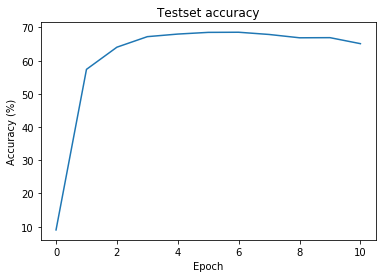

In [7]:
helpers.plot_test_acc(output_dir)

In [8]:
fp_paths, ip_paths, norms_paths, graph_specs = save_results(output_dir, layers)

Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-conv1.npy
Saved inner products to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/inner_products-conv1.npy
Saved weight vector norms to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/weight_norms-conv1.npy
Saved adjacency matrix to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/adjacency-conv1.npy
Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-conv2.npy
Saved inner products to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/inner_products-conv2.npy
Saved weight vector norms to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/weight_norms-conv2.npy
Saved adjacency matrix to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/adjacency-conv2.npy
Saved frame potentials to: out/Conv2-unbiased-29_10_2019-09:01:19/metrics/training/frame_potentials-fc1.npy
Saved inner products to: out/Conv2-u

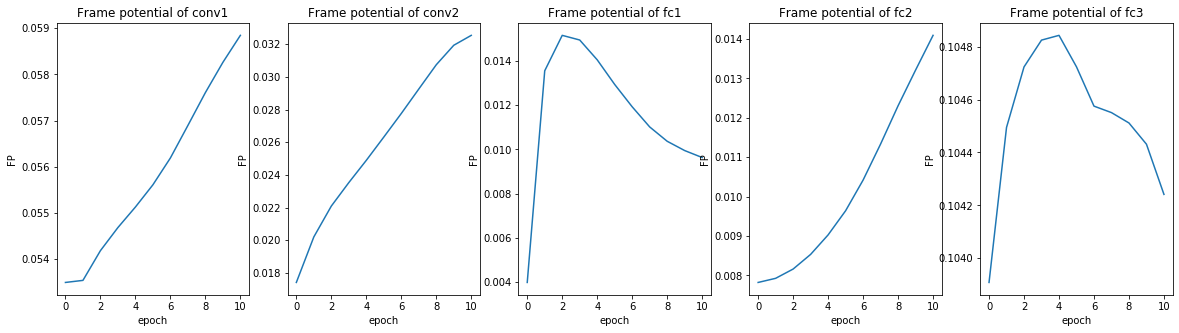

In [9]:
helpers.plot_train_fps(fp_paths, layers)

### Analysis of a layer

In [15]:
layer = layers[3]
weight_norms = np.load(norms_paths[layer])
adjacency, kernel_width = graph_specs[layer]

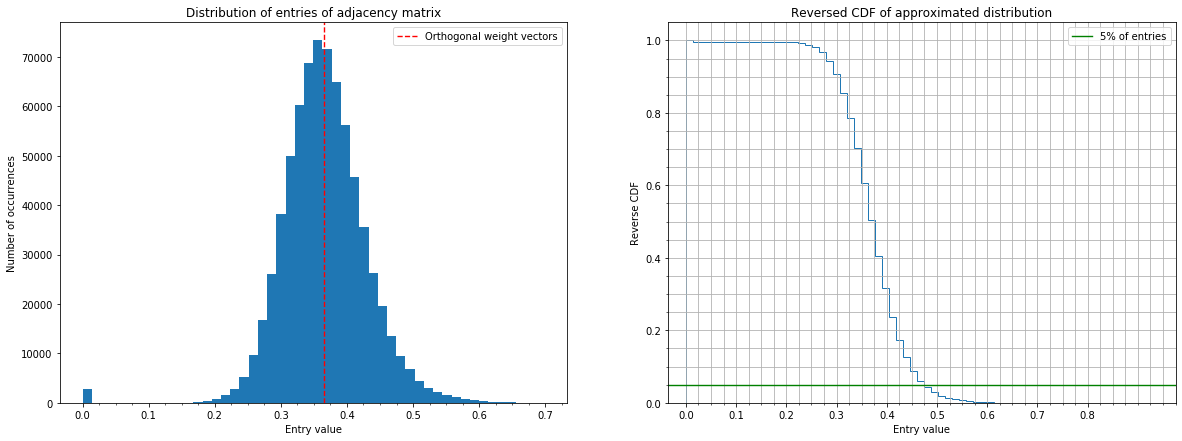

In [16]:
statistics.weight_dist(adjacency, kernel_width)

In [17]:
min_cut_off = 0.45

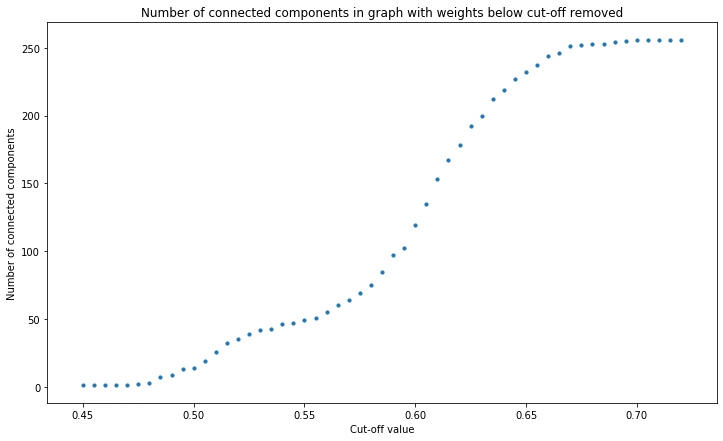

In [18]:
cut_offs = statistics.plot_connected_components(adjacency, min_cut_off)

In [19]:
plot_data = statistics.cc_max_norm(adjacency, weight_norms, cut_offs)
int_slider = IntSlider(value=0, min=0, max=len(plot_data)-1)
interact(statistics.cc_specs_plot, plot_data=fixed(plot_data), cut_offs=fixed(cut_offs), idx=int_slider);

interactive(children=(IntSlider(value=0, description='idx', max=54), Output()), _dom_classes=('widget-interact…